In [21]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import math

In [22]:
# Number of clients
n = 30
# Read input data of clients, filter on number of clients
data = pd.read_csv('data/clients.csv', sep=';')
clients = data.iloc[:n]

In [23]:
# Depot index and its coordinates
depot, dep_x, dep_y = 0, 150, 150
# Extract data
xc = [dep_x] + data['xcord'].tolist()
yc = [dep_y] + data['ycord'].tolist()
demand = data['demand'].tolist()

In [24]:
# Problem setup
# Set of clients
N = [i for i in range(1, n+1)]
# Set of vertices
V = [depot] + N
# Set of arcs, {(i,j) in V^2 : i != j}
A = [(i,j) for i in V for j in V if i != j]
# Distance metric, euclidean
def distance(i,j):
    return float(np.hypot(xc[i] - xc[j], yc[i] - yc[j]))

# Cost of travelling between nodes
c = {(i,j): distance(i,j) for i,j in A}
# Capacity of agents
Q = 10
# Demand per client
q = {i: demand[i-1] for i in N}

Minimum number of agents to fulfill all demand: 7.5 -> 8


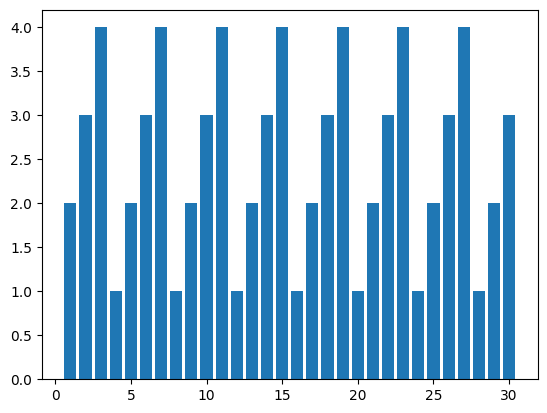

In [25]:
clients = np.array(list(q.keys()))
demand = np.array(list(q.values()))
plt.bar(clients, demand)
b = sum(list(q.values())) / Q
nr_of_vehicles = int(np.ceil(b))
print('Minimum number of agents to fulfill all demand:', b, '->', nr_of_vehicles)

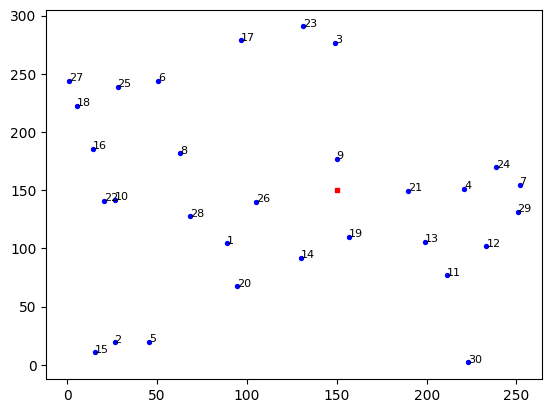

In [26]:
# Visualization of map
plt.figure()
size = 8
# Plot home depot with red
plt.scatter(xc[depot], yc[depot], c='r', marker='s', s=size)
# Plot clients locations with blue markers
for i in N:
    plt.scatter(xc[i], yc[i], c='b', s=size)
    plt.text(xc[i], yc[i], str(i), fontsize=8)


In [27]:

def initial_solution(max_vehicles):
    routes = [[] for _ in range(max_vehicles)] # Pre-allocate number of routes
    remaining_nodes = set(N)

    # Sort nodes by descending demand
    sorted_nodes = sorted(remaining_nodes, key=lambda x: -q[x])

    for node in sorted_nodes:

        # Assign the node to the least-loaded route
        least_loaded_route = min(routes, key=lambda r: sum(q[i] for i in r))
        least_loaded_route.append(node)

    # Remove empty routes:
    routes = [route for route in routes if route]
    return routes

In [28]:
solution_example = initial_solution(nr_of_vehicles)
print(solution_example)

[[3, 10, 13, 20], [7, 14, 17, 24], [11, 18, 21, 28], [15, 22, 25], [19, 26, 29], [23, 30, 4, 8], [27, 1, 5, 12], [2, 6, 9, 16]]


In [29]:
# Calculate the total cost of a solution
def total_cost(routes):

    cost = 0

    for route in routes:
        # Calculate cost of route
        if len(route) > 0:
            route_cost = distance(depot, route[0]) # Start at depot
            for i in range(len(route) - 1):
                route_cost += distance(route[i], route[i+1]) # + q[route[i+1]]
            route_cost += distance(route[-1], depot) # Return to depot
            cost += route_cost


    return cost

Text(0.5, 1.0, 'Total cost: 5459.32')

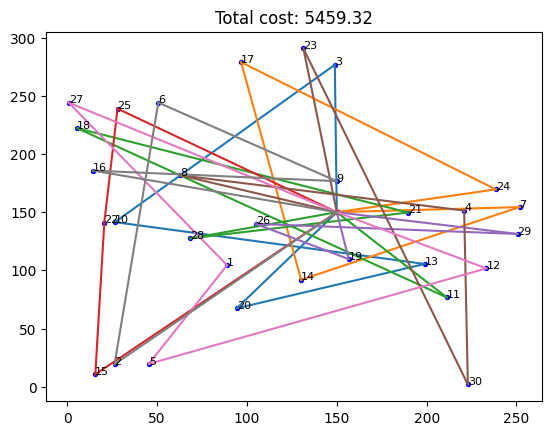

In [30]:
paths = []
for route in solution_example:
    path = []
    for i, node in enumerate(route):
        if i == 0:
            path.append((depot,node))
        else:
            path.append((route[i-1], node))
    path.append((route[-1], depot))
    paths.append(path)

# Visualization of map
plt.figure()
size = 8
# Plot home depot with red
plt.scatter(xc[depot], yc[depot], c='r', marker='s', s=size)
# Plot clients locations with blue markers
for i in N:
    plt.scatter(xc[i], yc[i], c='b', s=size)
    plt.text(xc[i], yc[i], str(i), fontsize=8)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for k, path in enumerate(paths):
    for i,j in path:
        plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c=colors[k%len(colors)])

plt.title('Total cost: {}'.format(round(total_cost(solution_example), 2)))

In [31]:
def cost_breakdown(solution):

    print(solution)
    total_route_distance = []
    total_route_demand = []
    for route in solution:
        # Calculate cost of route
        if len(route) > 0:
            route_cost = distance(depot, route[0]) + q[route[0]] # Start at depot
            for i in range(len(route) - 1):
                route_cost += distance(route[i], route[i+1]) + q[route[i+1]]
            route_cost += distance(route[-1], depot) # Return to depot
            total_route_distance.append(route_cost)
    
    for route in solution:
        route_demand = sum([float(q[i]) for i in route])
        total_route_demand.append(route_demand)

    return total_route_distance, total_route_demand


In [32]:
# Check if a solution is feasible
def is_feasible(routes, max_vehicles):
    """
    Check if a solution is feasible:
    A) Each route's total demand must not exceed the vehicle capacity
    B) The number of routes must not exceed the maximum allowed vehicles
    """
    # A) Allowed, but penalized

    for route in routes:
        if sum(q[i] for i in route) > Q:
            return False
    # B)
    if len(routes) > max_vehicles:
        return False
    
    return True

In [33]:
# Perform a random move
def move_operation(routes, max_vehicles):
    """
    Perform a move operation:
    1. Swap two customers within a single route.
    2. Move a customer from one route to another.
    3. Swap customers between two different routes.
    4. Merge routes if the number of routes exceeds max_vehicles.

    Parameters:
    - routes: List of vehicle routes (each route is a list of customers).
    - max_vehicles: Maximum number of allowed routes.
    - q: Dictionary of customer demands.
    - Q: Vehicle capacity.
    - c: Cost matrix (for merging cost calculations).

    Returns:
    - new_routes: Updated list of routes after performing the move.
    """

    move_type = random.random()

    new_routes = [list(route) for route in routes]
    # Choose a random route and modify it
    if move_type < 0.33:
        # Swap two customers within the same route
        route = random.choice(new_routes)
        if len(route) > 1:
            i, j = random.sample(range(len(route)), 2)
            route[i], route[j] = route[j], route[i]
        
    elif move_type < 0.66:
        # Move a customer from one route to another
        if len(new_routes) > 1:
            start_route = random.choice(new_routes)
            target_route = random.choice(new_routes)

            if start_route:
                customer = start_route.pop(random.randrange(len(start_route)))

                # Check if adding the customer keeps the target route within capacity
                if sum(q[i] for i in target_route) + q[customer] <= Q:
                    target_route.append(customer)
                else:
                    start_route.append(customer) # Reverse move if infeasible

    else:
        # Swap customers between two different routes
        if len(new_routes) > 1:
            route1, route2 = random.sample(new_routes, 2)

            if route1 and route2:
                idx1 = random.randrange(len(route1))
                idx2 = random.randrange(len(route2))

                # Swap the customers
                route1[idx1], route2[idx2] = route2[idx2], route1[idx1]

                # Ensure feasibility after swap
                if sum(q[i] for i in route1) > Q or sum(q[i] for i in route2) > Q:
                    # Revert the swap if infeasible
                    route1[idx1], route2[idx2] = route2[idx2], route1[idx1]


    # Ensure the number of routes does not exceed the maximum allowed
    while len(new_routes) > max_vehicles:
        # Find pair of routes with the lowest combined cost
        best_merge = None
        best_merge_cost = float('inf')
        for i, route1 in enumerate(new_routes):
            for j, route2 in enumerate(new_routes):

                if i >= j: # Avoid duplicate pairs and self-pairs
                    continue
                # Compute the combined cost of merging route1 and route2
                merged_route = route1+ route2
                merged_cost = sum(c[merged_route[k], merged_route[k+1]] for k in range(len(merged_route)-1)) # TODO: Maybe create a function to calculate cost of route, embed into total_cost aswell
                if merged_cost < best_merge_cost:
                    best_merge = (i,j)
                    best_merge_cost = merged_cost

        # Merge the two routes with the lowest combined cost
        if best_merge:
            i, j = best_merge
            new_routes[i] += new_routes[j]
            del new_routes[j] # Remove the second route
    
    return new_routes

In [34]:
# --- Simulated annealing algorithm
def simulated_annealing(max_vehicles, init_solution):
    # Parameters
    T = 1000 # Initial temperature
    alpha = 0.995 # Cooling rate
    min_T = 0.1 # Minimum temperature
    max_iterations = 1000 # Maximum iterations at each temperature

    # Initial solution
    if not init_solution:
        current_solution = initial_solution(max_vehicles)
    else:
        current_solution = init_solution
    
    while len(current_solution) < max_vehicles:
        current_solution.append([])


    current_cost = total_cost(current_solution)
    best_solution = current_solution
    best_cost = current_cost

    # Data for plotting
    temperatures = []
    current_costs = []
    best_costs = []

    iteration = 0 # Keep track of iterations
    while T > min_T:
        for _ in range(max_iterations):
            iteration += 1
            # Generate a neighbour solution
            neighbour = move_operation(current_solution, max_vehicles)
            if not is_feasible(neighbour, max_vehicles):
                continue

            neighbour_cost = total_cost(neighbour)
            # Acceptance probability
            if neighbour_cost < current_cost or random.random() < math.exp((current_cost-neighbour_cost) / T):
                current_solution = neighbour
                current_cost = neighbour_cost
                # Update the best solution
                if current_cost < best_cost:
                    best_solution = current_solution
                    best_cost = current_cost
                    print('Iteration {}: New best solution found.'.format(iteration))
                    print('Routes: {}'.format(best_solution))
                    print('Cost: {}'.format(best_cost))
                    print('---')
                
            # Track data for plots
            temperatures.append(T)
            current_costs.append(current_cost)
            best_costs.append(best_cost)
        
        # Debug print at each temperature step
        print('Temperature: {}, Current cost: {}, Best Cost: {}'.format(round(T, 3), round(current_cost, 2), round(best_cost, 2)))

        # Cool down
        T *= alpha

    # Final best solution
    print('--- Final best folution:')
    print('Routes: {}'.format(best_solution))
    print('Cost: {}'.format(best_cost))

    # Remove empty routes
    best_solution = [route for route in best_solution if route]

    return best_solution, best_cost, temperatures, current_costs, best_costs


In [35]:
# Run the algorithm
t0 = time.time()
best_routes, best_cost, temperatures, current_costs, best_costs = simulated_annealing(nr_of_vehicles, solution_example)
t1 = time.time()

Iteration 2: New best solution found.
Routes: [[3, 10, 13, 20], [7, 14, 17, 24], [18, 21, 28, 11], [15, 22, 25], [19, 26, 29], [23, 30, 4, 8], [27, 1, 5, 12], [2, 6, 9, 16]]
Cost: 5435.802059524207
---
Iteration 3: New best solution found.
Routes: [[3, 10, 13, 20], [7, 14, 17, 24], [18, 21, 28, 26], [15, 22, 25], [19, 11, 29], [23, 30, 4, 8], [27, 1, 5, 12], [2, 6, 9, 16]]
Cost: 5198.394990407832
---
Iteration 4: New best solution found.
Routes: [[3, 10, 13, 20], [7, 14, 17, 24], [18, 21, 28, 26], [15, 22, 25], [19, 11, 29], [23, 4, 30, 8], [27, 1, 5, 12], [2, 6, 9, 16]]
Cost: 5140.871245237276
---
Iteration 5: New best solution found.
Routes: [[3, 10, 13, 20], [7, 14, 17, 24], [18, 21, 28, 26], [15, 22, 25], [19, 11, 29], [23, 4, 30, 8], [27, 1, 5, 12], [2, 6, 16, 9]]
Cost: 4976.020956651114
---
Iteration 7: New best solution found.
Routes: [[15, 10, 13, 20], [7, 14, 24, 17], [18, 21, 28, 26], [3, 22, 25], [19, 11, 29], [23, 4, 30, 8], [27, 1, 5, 12], [2, 6, 16, 9]]
Cost: 4973.1783717

In [36]:
print('Total duration:', round(t1 - t0, 2), ' seconds.')

Total duration: 95.32  seconds.


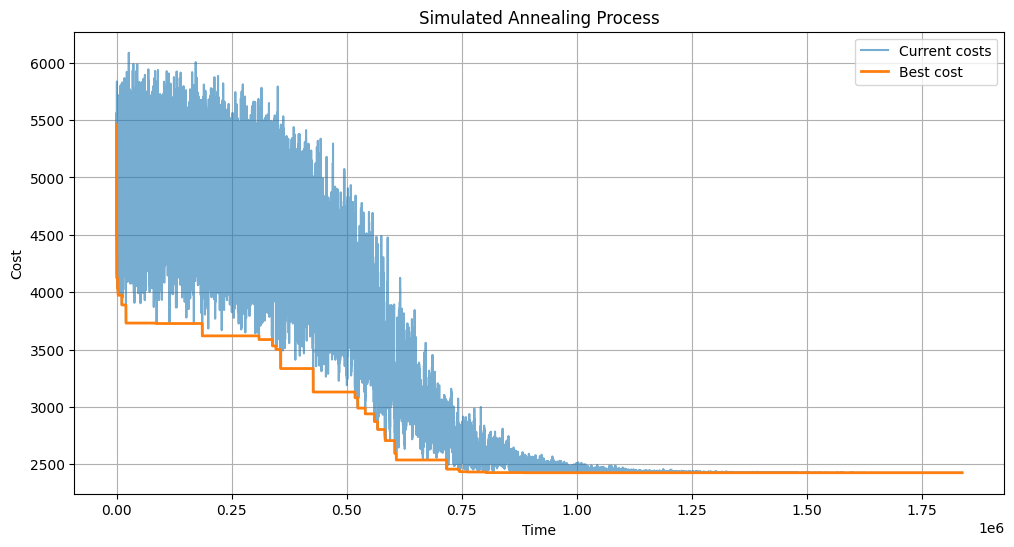

In [37]:
# Plot results
plt.figure(figsize=(12,6))
x = range(len(temperatures))
plt.plot(x, current_costs, label='Current costs', alpha=0.6)
plt.plot(x, best_costs, label='Best cost', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Cost')
plt.title('Simulated Annealing Process')
plt.legend()
plt.grid()
plt.show()

In [38]:
paths = []
for route in best_routes:
    if len(route) > 0:
        path = []
        for i, node in enumerate(route):
            if i == 0:
                path.append((depot,node))
            else:
                path.append((route[i-1], node))
        path.append((route[-1], depot))
        paths.append(path)

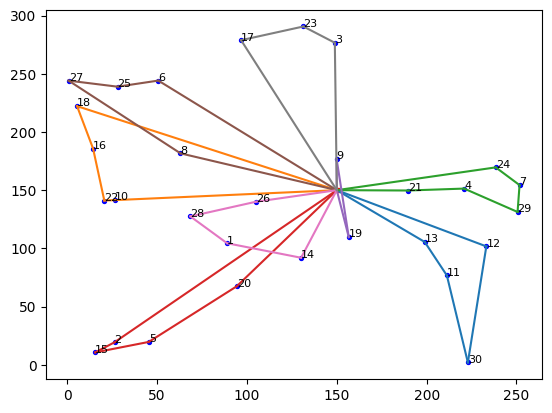

In [39]:
# Plot home depot with red
plt.scatter(xc[depot], yc[depot], c='r', marker='s', s=size)
# Plot clients locations with blue markers
for i in N:
    plt.scatter(xc[i], yc[i], c='b', s=size)
    plt.text(xc[i], yc[i], str(i), fontsize=8)


for k, path in enumerate(paths):
    for i,j in path:
        plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c=colors[k%len(colors)])

[[12, 30, 11, 13], [18, 16, 22, 10], [24, 7, 29, 4, 21], [2, 15, 5, 20], [19, 9], [6, 25, 27, 8], [14, 1, 28, 26], [3, 23, 17]]


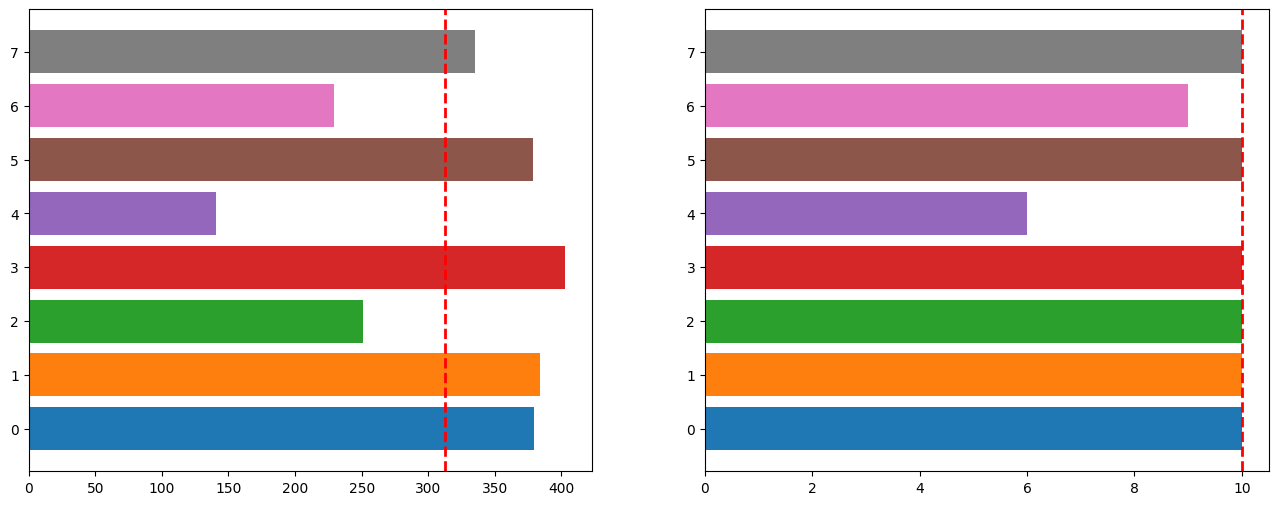

In [40]:
total_route_distance, total_route_demand = cost_breakdown(best_routes)

fig, ax = plt.subplots(1, 2, figsize=(16,6))
ax[0].barh(range(len(best_routes)), total_route_distance, color=colors)
ax[0].axvline(x=np.mean(total_route_distance), color='red', linestyle='--', linewidth=2)

ax[1].barh(range(len(best_routes)), total_route_demand, color=colors)
ax[1].axvline(x=Q, color='red', linestyle='--', linewidth=2)
plt.show()